In [1]:
import os 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import tifffile

In [2]:
# Path to the slices 
data_dir = 'D:\sagar\Data\MD_1264_A6_1_Z3.3mm_corr_phrt\slices'
tiffs = os.listdir(data_dir)

In [3]:
# Reading all the slices in a Volume 
vol = np.empty(shape=(1700, 3681, 3681), dtype=np.float32)
for i, fname in enumerate(tqdm(tiffs)):
    im = Image.open(os.path.join(data_dir, fname))
    imarray = np.array(im)
    vol[i, :, :] = imarray

100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [08:47<00:00,  3.22it/s]


In [4]:
# Reading all the slices in a Volume 
vol = []
for fname in tqdm(tiffs):
    im = Image.open(os.path.join(data_dir, fname))
    imarray = np.array(im)
    vol.append(imarray)

vol = np.asarray(vol)

100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [07:58<00:00,  3.55it/s]


In [4]:
print(vol.shape)

(1700, 3681, 3681)


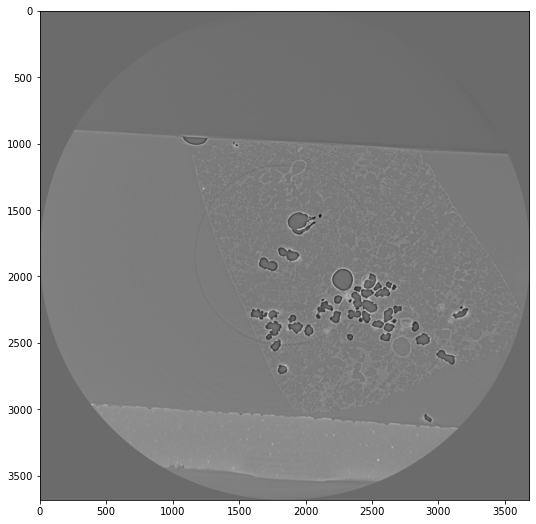

In [5]:
#Ploting the middle slice 
plt.figure(figsize=(16,9))
plt.imshow(vol[850, :, :], cmap='gray')
plt.show()

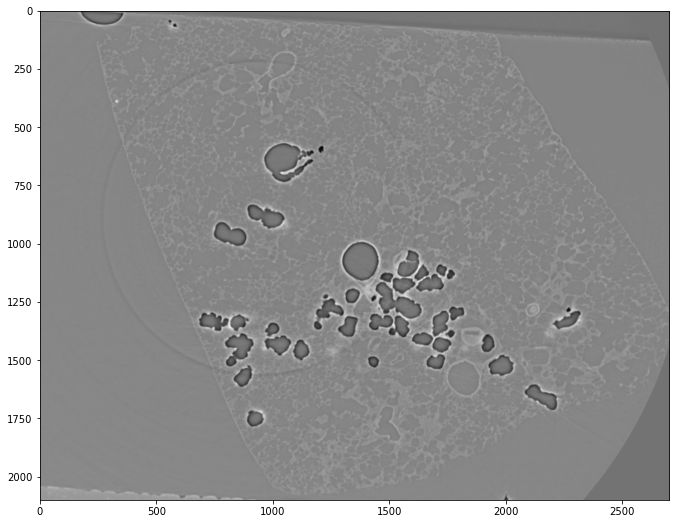

In [6]:
#Ploting the middle slice 
plt.figure(figsize=(16,9))
plt.imshow(vol[850, 950:3681-631, 900:3681-81], cmap='gray')
plt.show()

In [13]:
xdim = vol.shape[1]
ydim = vol.shape[2]
zdim = vol.shape[0]

# Offset for ROI volume
# Have to check manually for each data (Maybe)

rowStartingOffset = 850
rowEndingOffset = 631

colStartingOffset = 800
colEndingOffset = 81

roi_vol = vol[:, rowStartingOffset:xdim-rowEndingOffset, colStartingOffset:ydim-colEndingOffset]

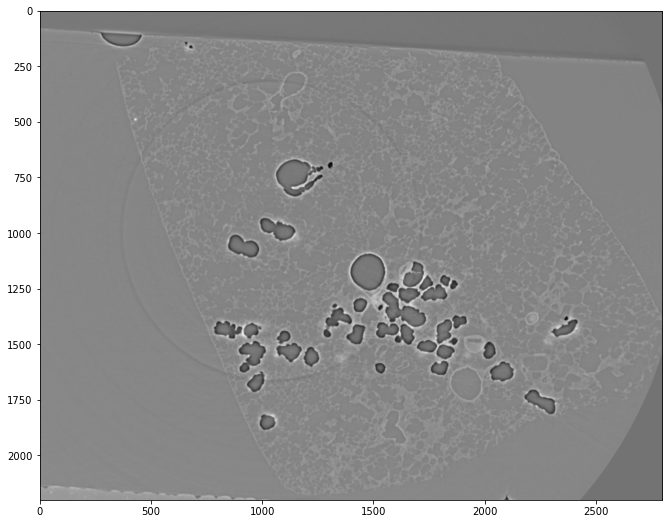

In [14]:
#Ploting the middle slice 
plt.figure(figsize=(16,9))
plt.imshow(roi_vol[850, :, :], cmap='gray')
plt.show()

In [15]:
roi_vol.shape

(1700, 2200, 2800)

In [16]:
# define the parameter for cliping the roi 

# size of 3D cube 
cube_size = 300
# step size in each direction
step_size = 200

In [17]:
# finding the range for the loop 
depth = roi_vol.shape[0]
row = roi_vol.shape[1]
col = roi_vol.shape[2]

In [18]:
print(list(range(0, depth, step_size)))
print(list(range(0, row-cube_size, step_size)))
print(list(range(0, col-cube_size, step_size)))

[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]
[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]


In [19]:
del vol 

In [20]:
# function to save slices of a volume into a defined folder 

def saveSlices(volume, folderName):
    depth = volume.shape[0]
    for aSlice in range(depth):
        img = volume[aSlice, :, :]
        if not os.path.exists(folderName):
            os.makedirs(folderName)
        fName = os.path.join(folderName, f'slice_{aSlice}.tif') 
        tifffile.imsave(fName, img)

In [21]:
minmax = {}
all_roi = []
mins = []
maxs = []

depthList = list(range(0, depth, step_size))

for d in tqdm(depthList[:-1]):
    for r in range(0, row-cube_size, step_size):
        for c in range(0, col-cube_size, step_size):
            cube = roi_vol[d:d+cube_size, r:r+cube_size, c:c+cube_size]
            
            roiName = f'{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}'
            all_roi.append(roiName)
            mins.append(cube.min())
            maxs.append(cube.max())
            
            
            #fileName = f'{os.path.dirname(data_dir)}\\tiles\\{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}.raw'
            #cube.tofile(fileName)
            
            pathName = f'{os.path.dirname(data_dir)}\\tiles\\{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}'
            saveSlices(cube, pathName)
            

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [07:13<00:00, 54.16s/it]


In [22]:
minList = []
for i in range(len(mins)):
    minList.append(mins[i].tolist())
    
maxList = []
for i in range(len(maxs)):
    maxList.append(maxs[i].tolist())

In [23]:
minmax = {}
minmax['roi'] = all_roi
minmax['min'] = minList
minmax['max'] = maxList

In [24]:
import json
jsonString = json.dumps(minmax)
jsonFile = open(data_dir.split('slices')[0] + 'tiles.json', "w")
jsonFile.write(jsonString)
jsonFile.close()